In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import torch
from torch import optim
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm

import torchvision

import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import torchmetrics

In [1]:
from load_cnn_data import prepare_cnn_dataset

# Function now returns train and test datasets split by image pairs
train_dataset, test_dataset = prepare_cnn_dataset(
    biofilm_path='biofilm_data/biofilm',
    release_cells_path='biofilm_data/release_cells',
    patch_size=28,
    normalize=True,
    train_split=0.8,
    random_state=42
)

PREPARING CNN DATASET WITH TRAIN/TEST SPLIT
Matching image pairs by XY identifier...
  Matched: Untreated_20x_XY01_Z160_CH2.tif <-> Untreated_60x_Z160_CH2_XY01.tif
  Matched: Untreated_20x_XY02_Z160_CH2.tif <-> Untreated_60x_Z160_CH2_XY02.tif
  Matched: Untreated_20x_XY03_Z160_CH2.tif <-> Untreated_60x_Z160_CH2_XY03.tif
  Matched: Untreated_20x_XY04_Z160_CH2.tif <-> Untreated_60x_Z160_CH2_XY04.tif
  Matched: Untreated_20x_XY05_Z160_CH2.tif <-> Untreated_60x_Z160_CH2_XY05.tif
  Matched: Untreated_20x_XY07_Z160_CH2.tif <-> Untreated_60x_Z160_CH2_XY07.tif
Found 6 matched pairs

Split into:
  Train: 4 image pairs (67%)
  Test: 2 image pairs (33%)

PROCESSING TRAIN PAIRS

Processing train pair 1/4:
  Biofilm: Untreated_20x_XY07_Z160_CH2.tif
  Release cell: Untreated_60x_Z160_CH2_XY07.tif
  Biofilm image shape: (480, 640)
  Biofilm mean pixel value (label): 76.92
  Release cell image shape: (480, 640)
  Extracted 374 patches of size 28x28

Processing train pair 2/4:
  Biofilm: Untreated_20x_

In [5]:
# Datasets are already split by image pairs (80/20)
# This ensures patches from the same image stay together
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
len(train_dataset), len(test_dataset)


Train dataset size: 1496
Test dataset size: 748


(1496, 748)

In [6]:
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
len(train_loader), len(test_loader)



(24, 12)

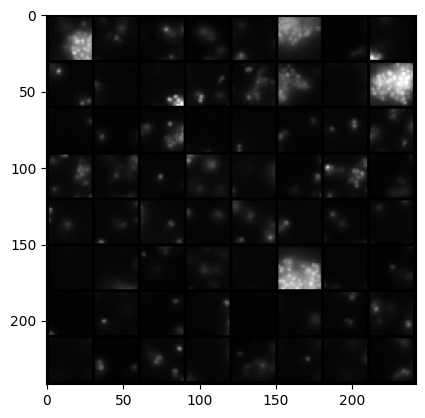

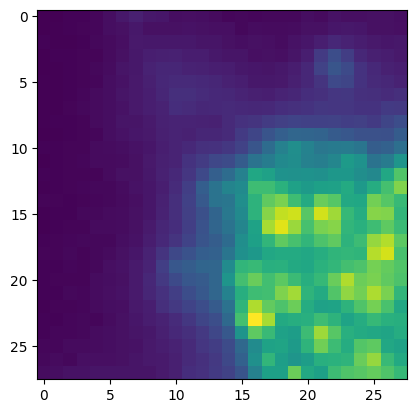

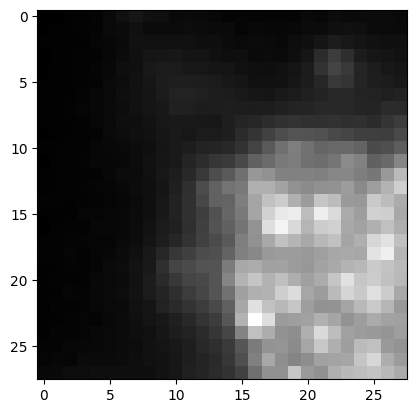

In [7]:
def imshow(img):
   npimg = img.numpy()
   plt.imshow(np.transpose(npimg, (1, 2, 0)))
   plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
labels
# show images
imshow(torchvision.utils.make_grid(images))
imshow(images[0])
# For grayscale images, squeeze out the channel dimension (1, 28, 28) -> (28, 28)
plt.imshow(images[0].squeeze(), cmap='gray')
plt.show()


In [8]:
class CNN(nn.Module):
   def __init__(self, in_channels, num_classes):

       """
       Building blocks of convolutional neural network.

       Parameters:
           * in_channels: Number of channels in the input image (for grayscale images, 1)
           * num_classes: Number of classes to predict. For regression, 1.
       """
       super(CNN, self).__init__()

       # 1st convolutional layer
       self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1)
       # Max pooling layer
       self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
       # 2nd convolutional layer
       self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)
       # Fully connected layer
       self.fc1 = nn.Linear(16 * 7 * 7, num_classes) # 7 * 7 for 28x28 images that were pooled twice down to 7x7

   def forward(self, x):
       """
       Define the forward pass of the neural network.

       Parameters:
           x: Input tensor.

       Returns:
           torch.Tensor
               The output tensor after passing through the network.
       """
       x = F.relu(self.conv1(x))  # Apply first convolution and ReLU activation
       x = self.pool(x)           # Apply max pooling
       x = F.relu(self.conv2(x))  # Apply second convolution and ReLU activation
       x = self.pool(x)           # Apply max pooling
       x = x.reshape(x.shape[0], -1)  # Flatten the tensor
       x = self.fc1(x)            # Apply fully connected layer
       return x


In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = CNN(in_channels=1, num_classes=1).to(device)
print(model)

CNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=784, out_features=1, bias=True)
)


In [10]:
# Define the loss function (MSELoss for regression)
criterion = nn.MSELoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [11]:
num_epochs=10
for epoch in range(num_epochs):
 # Iterate over training batches
   print(f"Epoch [{epoch + 1}/{num_epochs}]")

   for batch_index, (data, targets) in enumerate(tqdm(train_loader)):
       data = data.to(device)
       targets = targets.to(device)
       # Reshape targets to match model output shape: (batch_size,) -> (batch_size, 1)
       targets = targets.view(-1, 1).float()
       scores = model(data)
       loss = criterion(scores, targets)
       optimizer.zero_grad()
       loss.backward()
       optimizer.step()

Epoch [1/10]


100%|██████████| 24/24 [00:00<00:00, 149.51it/s]


Epoch [2/10]


100%|██████████| 24/24 [00:00<00:00, 180.62it/s]


Epoch [3/10]


100%|██████████| 24/24 [00:00<00:00, 189.83it/s]


Epoch [4/10]


100%|██████████| 24/24 [00:00<00:00, 188.10it/s]


Epoch [5/10]


100%|██████████| 24/24 [00:00<00:00, 176.24it/s]


Epoch [6/10]


100%|██████████| 24/24 [00:00<00:00, 177.14it/s]


Epoch [7/10]


100%|██████████| 24/24 [00:00<00:00, 181.49it/s]


Epoch [8/10]


100%|██████████| 24/24 [00:00<00:00, 184.95it/s]


Epoch [9/10]


100%|██████████| 24/24 [00:00<00:00, 184.43it/s]


Epoch [10/10]


100%|██████████| 24/24 [00:00<00:00, 181.64it/s]


In [ ]:
# Set up regression metrics
mae_metric = torchmetrics.MeanAbsoluteError()
mse_metric = torchmetrics.MeanSquaredError()
rmse_metric = torchmetrics.MeanSquaredError(squared=False)

model.eval()
with torch.no_grad():
    for data, targets in test_loader:
        data = data.to(device)
        targets = targets.to(device)
        # Reshape targets if necessary
        targets = targets.view(-1, 1).float()
        outputs = model(data)
        mae_metric.update(outputs, targets)
        mse_metric.update(outputs, targets)
        rmse_metric.update(outputs, targets)

# Compute test regression metrics
test_mae = mae_metric.compute()
test_mse = mse_metric.compute()
test_rmse = rmse_metric.compute()

print(f"Test MAE: {test_mae}")
print(f"Test MSE: {test_mse}")
print(f"Test RMSE: {test_rmse}")

Test MAE: 0.2074180245399475
Test MSE: 0.04462272673845291
Test RMSE: 0.21124091744422913
